# Detect Thunderstorms

Criteria for Thunderstorm detection:

* VIL is larger than ...
* Total cell with VIL>=... accounts for more than % of the area

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from herbie import Herbie
import numpy as np

In [3]:
H = Herbie(
    "2021-09-02 16:30",  # model run date
    model="hrrr",  # model name
    product="sfc",  # model produce name (model dependent)
    fxx=0,  # forecast lead time
)

H.download(":VIL:")

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2021-Sep-02 16:30 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


PosixPath('/Users/thinhhoang/data/hrrr/20210902/subset_adef0967__hrrr.t16z.wrfsfcf00.grib2')

In [4]:
ds = H.xarray(":VIL:")
vil = ds.veril

/Users/thinhhoang/miniforge3/envs/traffic/lib/python3.9/site-packages/herbie/core.py:1052: UserWarning: Will not remove GRIB file because it previously existed.
  warnings.warn("Will not remove GRIB file because it previously existed.")


In [5]:
from matplotlib.patches import Rectangle

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

Lambert = ccrs.LambertConformal()

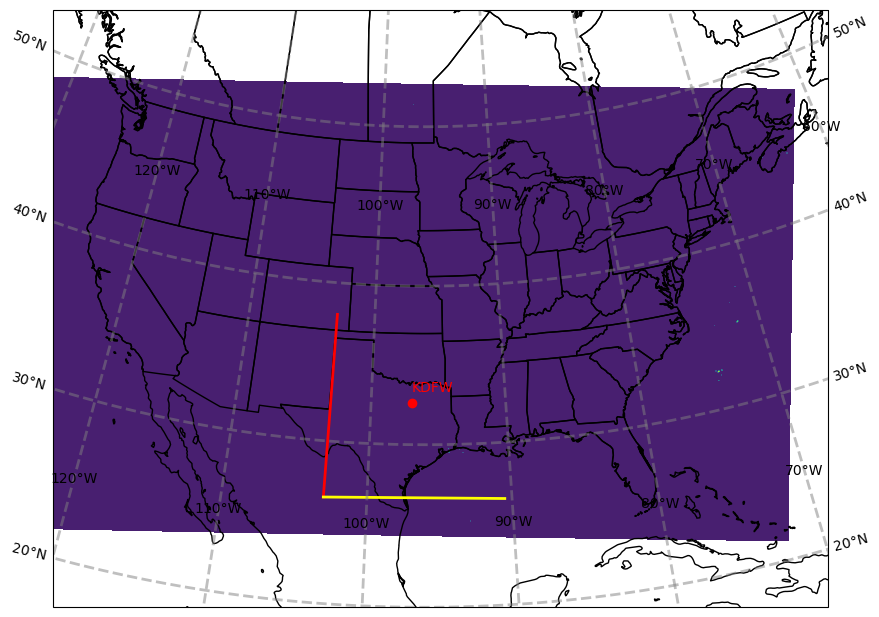

In [6]:
from roi import KDFW, WX_ROI
# Plot the veril using cartopy

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=Lambert)
ax.coastlines()
ax.add_feature(ccrs.cartopy.feature.STATES)

# Set the map bounds
ax.set_extent([-120, -70, 20, 55], crs=ccrs.PlateCarree())

# Draw two lines, one for each meridian and parallel that we want to highlight.
ax.plot([WX_ROI[0][0], WX_ROI[0][0]], [WX_ROI[1][0], WX_ROI[1][1]], color='red', transform=ccrs.PlateCarree(), linewidth=2)
ax.plot([WX_ROI[0][0], WX_ROI[0][1]], [WX_ROI[1][0], WX_ROI[1][0]], color='yellow', transform=ccrs.PlateCarree(), linewidth=2)

plt.contourf(vil['longitude'].values, vil['latitude'].values, vil.values, transform=ccrs.PlateCarree())
plt.scatter(KDFW[0], KDFW[1], color='red', transform=ccrs.PlateCarree())
plt.text(KDFW[0], KDFW[1]+0.75, 'KDFW', color='red', transform=ccrs.PlateCarree())

# Show the longitude and latitude grid lines
ax.gridlines(draw_labels=True, linewidth=2, color='gray', alpha=0.5, linestyle='--')



# Slicing the GRIB

Since we only care about the region of interest, we will extract the xarray of the VIL restricted to the ROI. To do so, we will load the gridpoints from the preamble.pkl file, verify if our GRIB is valid (i.e., holding the same geographical gridpoints).

After that, we will also build the statistics for non-zero values of VIL, which is useful for determination of threshold values, used to detect thunderstorms later.

In [27]:
import pickle as pkl 

with open('preamble.pkl', 'rb') as f:
    preamble = pkl.load(f)
    
preamble

{'longitude': array([-99.63075696, -99.60124454, -99.57173168, ..., -90.58433069,
        -90.55019507, -90.51606137]),
 'latitude': array([26.50050653, 26.50111384, 26.50171268, ..., 37.99582703,
        37.9937969 , 37.99175679]),
 'mask': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'roi': [(-103, -90.5), (26.5, 38)],
 'kdfw': [-96.973496106, 32.584330996],
 'KDFW': [-96.973496106, 32.584330996],
 'roi_id': ((82, 518), (713, 1136))}

Verify if all gridpoints are valid

In [28]:
import numpy as np

# Check if all the longitudes and latitudes are contained in the model data
if (np.isin(preamble['longitude'], vil['longitude'].values.flatten() - 360).all()):
    print('All longitudes are contained in the model data')
    
if (np.isin(preamble['latitude'], vil['latitude'].values.flatten()).all()):
    print('All latitudes are contained in the model data')
    


All longitudes are contained in the model data
All latitudes are contained in the model data


Now we are going to apply the mask and then downsample the VIL density of the ROI

In [53]:
# Applying the ROI mask to the VIL data (zero-ing out the values outside the ROI)
vilv = vil.values
vil_roignee = np.where(preamble['mask'], vilv, 0)
vil_roignee_cropped = vil_roignee[preamble['roi_id'][0][0]:preamble['roi_id'][0][1], preamble['roi_id'][1][0]:preamble['roi_id'][1][1]]
print('Cropped shape: ', vil_roignee_cropped.shape)

Cropped shape:  (436, 423)


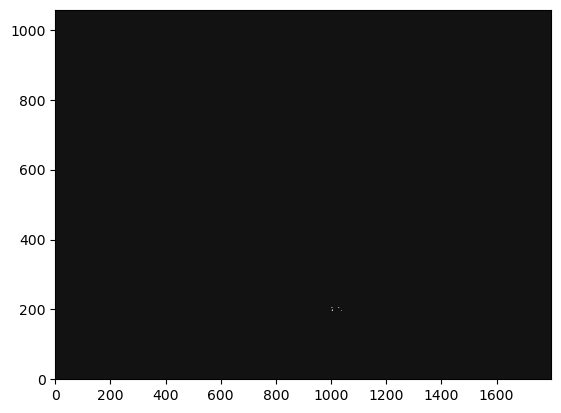

In [54]:
plt.contourf(vil_roignee, cmap='gray')

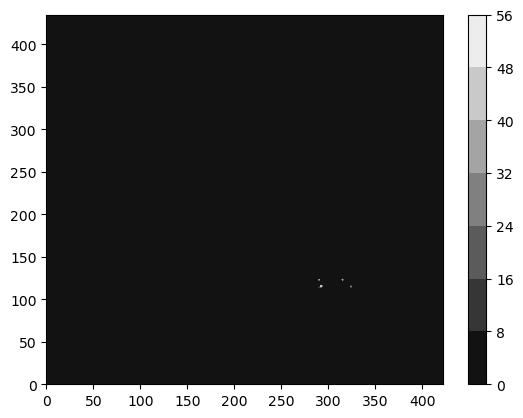

In [55]:
plt.contourf(vil_roignee_cropped, cmap='gray')
plt.colorbar()

In [56]:
def bin_nxm_rectangles_to_sum(array, n, m):
    # Check if the array dimensions are divisible by n and m
    if array.shape[0] % n != 0 or array.shape[1] % m != 0:
        # Pad the array so that the shape is divisible by n x m
        array = np.pad(array, ((0, n - array.shape[0] % n), (0, m - array.shape[1] % m)))
    
    # Reshape the array to a new 4D array and then sum over the last two axes to bin the elements
    binned_array = array.reshape(array.shape[0]//n, n, array.shape[1]//m, m).sum(axis=(1,3))
    return binned_array


In [57]:
# Downsample the VIL data to 1/4 degree resolution
vil_roignee_cropped_ds = bin_nxm_rectangles_to_sum(vil_roignee_cropped, 28, 28)
print('Shape of the downsampled VIL data: ', vil_roignee_cropped_ds.shape)

Shape of the downsampled VIL data:  (16, 16)


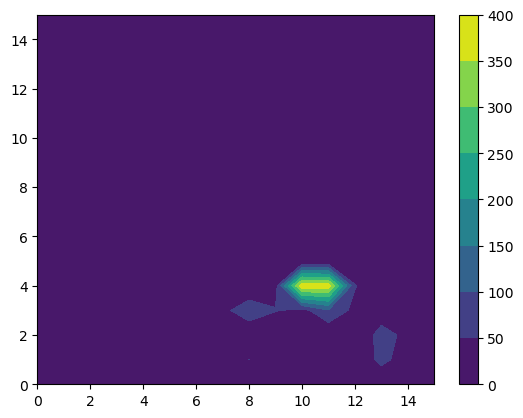

In [60]:
plt.contourf(vil_roignee_cropped_ds)
plt.colorbar()

Now we can save this to a separate file, which forms part of the dataset